In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import random
import cv2
from time import time
from datetime import datetime, timedelta
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
### Helper functions
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [3]:
# Create the features dictionary.
def image_example(image, label):
    feature = {
        'label': _bytes_feature(label.tobytes()),
        'image_raw': _bytes_feature(image.tobytes()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [4]:
import json
with open('config.json', 'r') as f:
    config = json.load(f)
    
img_shape = config["img_shape"]

In [5]:
list_dir = '~/kaggle_datasets/plant-pathology-2021-fgvc8/train.csv'
if os.name == 'nt':
    list_dir = r"E:\Documents\kaggle_datasets\plant-pathology-2021-fgvc8\train.csv"
    
df = pd.read_csv(list_dir, index_col='image').to_dict()
data = df['labels']
keys=["healthy", "scab", "frog_eye_leaf_spot", "rust", "complex", "powdery_mildew"]

def text_to_vec(value, keys):
    out = np.zeros(len(keys), np.float32)
    for i, key in enumerate(keys):
        if key in value:
            out[i] = 1
    assert out.sum() > 0, print(value, out)
    return out

for img in data:
    data[img] = text_to_vec(data[img], keys)

images = list(data.keys())
random.shuffle(images)

def rgb(img):
    return img[..., ::-1]

def pre_proc(img):
    return img
    dist = (img/255 - (img/255).mean(0).mean(0)[None, None, ...]).sum(-1)[..., None]
    img_orig = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(float)
    mult = np.ones_like(img_orig)
    add = np.ones_like(img_orig)
    
    mult[..., 0] *= 1
    add[..., 0] += 0
    
    mult[..., 1] *= 1.5
    add[..., 1] += -255//4
    
    mult[..., 2] *= 0.5
    add[..., 2] += 255//4
    
    img = img_orig * mult
    img += dist
    
    img = img*dist + img_orig*(1-dist)
    
    img = np.minimum(np.maximum(img, 0), 255)
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return img

def normalize(img):
    return img/255

def resize(img):
    return cv2.resize(img, (img_shape, img_shape))

def gen():
    img_dir = '~/kaggle_datasets/plant-pathology-2021-fgvc8/train_images/'
    if os.name == 'nt':
        img_dir = r"E:\Documents\kaggle_datasets\plant-pathology-2021-fgvc8\train_images" + "\\"
    for img in images:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        I = cv2.imread(img_dir + img)
        I = rgb(I)
        I = resize(I)
        ax1.imshow(I)
        I = pre_proc(I)
        ax2.imshow(I)
        plt.show()
        I = np.array(I, np.float32)
        I = normalize(I)
        x = tf.convert_to_tensor(I, dtype=tf.float32)
        I = None
        y = tf.convert_to_tensor(data[img], dtype=tf.float32)
        yield x, y

In [6]:
mean = np.zeros(6)
for k in df['labels']:
    mean += df['labels'][k]
mean = mean/len(df['labels'])
print(mean.mean()/mean)
sample_weigths = tf.convert_to_tensor([[0.72761678, 0.58902311, 0.77309283, 1.61988445, 1.56415621, 2.64712825]])
print(sample_weigths)

[0.72761678 0.58902311 0.77309283 1.61988445 1.56415621 2.64712825]
tf.Tensor([[0.7276168 0.5890231 0.7730928 1.6198845 1.5641562 2.6471283]], shape=(1, 6), dtype=float32)


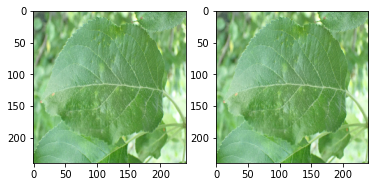

[==================================================] 18632/18632 ETA: 25/05/21, 15:04:03                                                                                                                


In [7]:
record_file = '~/kaggle_datasets/plant-pathology-2021-fgvc8/dataset.tfrecords'
if os.name == 'nt':
    record_file = r"E:\Documents\kaggle_datasets\plant-pathology-2021-fgvc8\dataset.tfrecords"

start = time()
template = ("[{}{}{}] {}/{} ETA: {}")
count = len(data)
def print_status(i):
    
    delta = count/i*(time() - start)
    end = datetime.fromtimestamp(start) + timedelta(seconds=delta)
    percent = int(i/count*100)
    print(" "*200, end="\r")
    print(template.format("="*(percent//2),
                          ">" if percent < 100 else "",
                          " "*(49 - percent//2),
                          i,
                          count,
                          end.strftime('%d/%m/%y, %H:%M:%S')))

generator = gen()

with tf.io.TFRecordWriter(record_file) as writer:
   for i, d in enumerate(generator):
      print_status(i+1)
      image = d[0]
      label = d[1]
      tf_example = image_example(image.numpy(), label.numpy())
      writer.write(tf_example.SerializeToString())

In [8]:
dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)

# Decoding function
def parse_record(record):
    name_to_features = {
        'label': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

def decode_record(record):
    record = parse_record(record)
    image = tf.io.decode_raw(
        record['image_raw'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    label = tf.io.decode_raw(
        record['label'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    image = tf.reshape(image, (img_shape, img_shape, 3))
    return (image, label)

dataset = dataset.map(decode_record).batch(32).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = 0
from time import time
s = time()
for d in dataset:
    e = time()
    print(d[0].shape, d[1].shape, e-s)
    s = time()

(32, 240, 240, 3) (32, 6) 1.1581854820251465
(32, 240, 240, 3) (32, 6) 1.11846923828125
(32, 240, 240, 3) (32, 6) 1.1080656051635742
(32, 240, 240, 3) (32, 6) 1.1123762130737305
(32, 240, 240, 3) (32, 6) 1.0986881256103516
(32, 240, 240, 3) (32, 6) 1.0991036891937256
(32, 240, 240, 3) (32, 6) 1.1078901290893555
(32, 240, 240, 3) (32, 6) 1.1074025630950928
(32, 240, 240, 3) (32, 6) 1.087902545928955
(32, 240, 240, 3) (32, 6) 1.094984531402588
(32, 240, 240, 3) (32, 6) 1.099719762802124
(32, 240, 240, 3) (32, 6) 1.1079893112182617
(32, 240, 240, 3) (32, 6) 1.1180408000946045
(32, 240, 240, 3) (32, 6) 1.1007957458496094
(32, 240, 240, 3) (32, 6) 1.113874912261963
(32, 240, 240, 3) (32, 6) 1.094095230102539
(32, 240, 240, 3) (32, 6) 1.0991544723510742
(32, 240, 240, 3) (32, 6) 1.0996572971343994
(32, 240, 240, 3) (32, 6) 1.099562168121338
(32, 240, 240, 3) (32, 6) 1.1228795051574707
(32, 240, 240, 3) (32, 6) 1.090662956237793
(32, 240, 240, 3) (32, 6) 1.1152563095092773
(32, 240, 240, 3) (